In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from boundary_solvers.gauss_grid_2d import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *

### Defining a boundary using gradient flow
One way to randomly deform a boundary is to use a potential field that continuously deforms the boundary points.

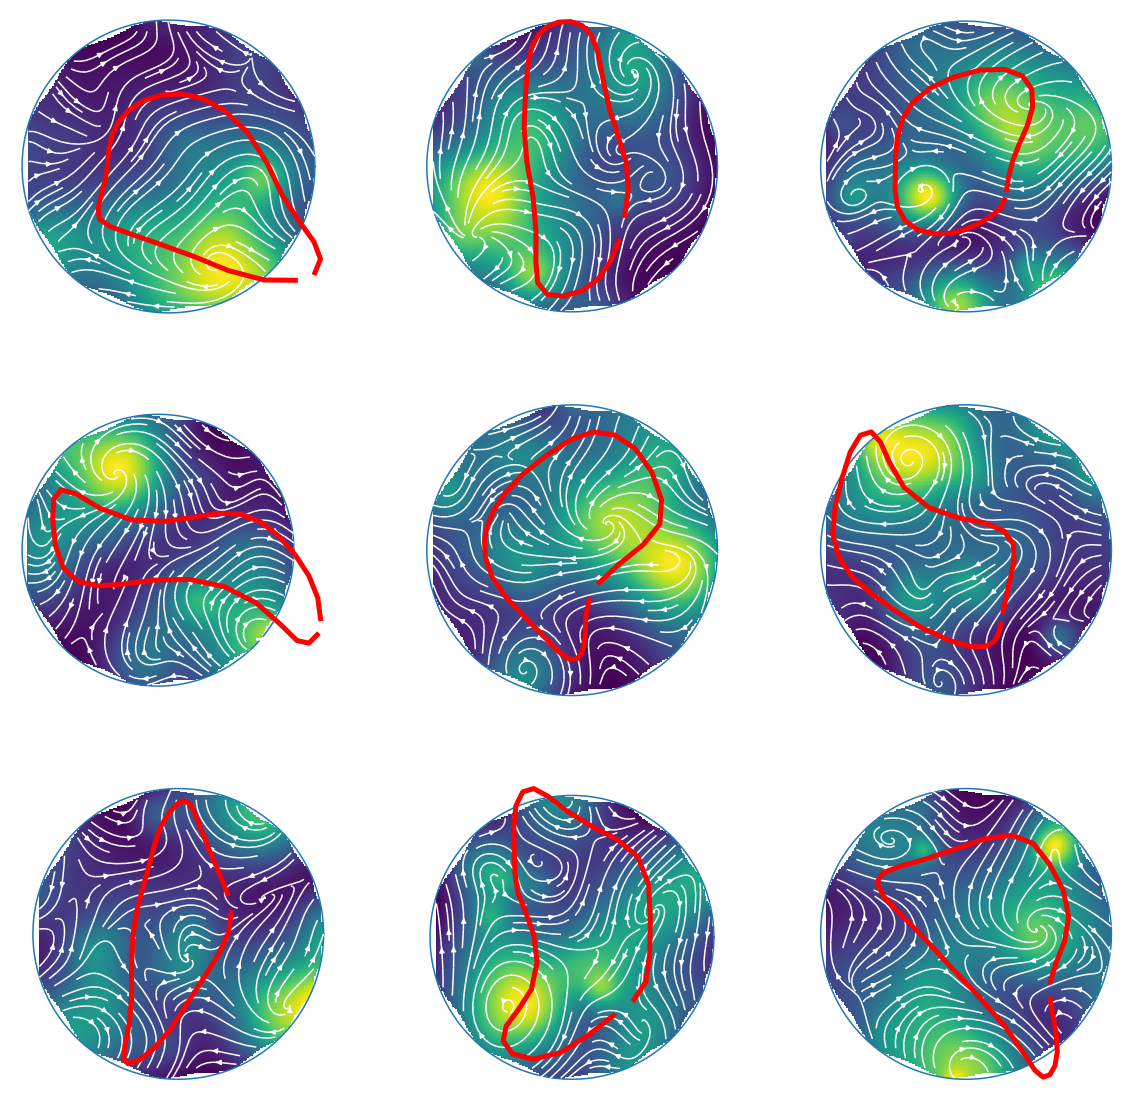

In [29]:
np.random.seed(0)
#domain
param = lambda t: 1.0*np.exp(1j * t)
dparam = lambda t: 1.0*np.exp(1j * t) * 1j
ddparam = lambda t: 1.0*np.exp(1j * t) * (1j)**2

M = 3
plt.figure(figsize=(20,20))
grid = GaussLegGrid(segments=np.linspace(0, 2*np.pi,2), corners=None)

pars = []
for i in range(M * M):
    print(f"Data {i}/{M*M}", end="\r")
    geom = GaussLegGeometry(param = [param, dparam, ddparam], grid=grid)

    n = 50
    L = 1.1
    means = np.random.uniform(low=-L, high=L, size=(1,n)) + 1j * np.random.uniform(low=-L,high=L,size=(1,n))
    #stds = np.abs(np.random.randn(1,n)) * .3
    stds = np.abs(np.random.randn(1,n)*0.1 + 0.3)
    
    amps = np.abs(np.random.randn(1,n))
    rot = np.exp(1j * (0.5*np.abs(np.random.randn(1,n)) + np.pi/2))

    def field(z):
        return np.sum(amps * np.exp(-np.abs((z-means)/stds)**2), axis=1)

    def flow(z):
        return np.sum(-amps * 2 *rot*(z-means) * np.exp(-np.abs((z-means)/stds)**2), axis=1)

    def deform(steps, dt):
        #t, w = grid.get_grid_and_weights()
        t = np.linspace(0, 2*np.pi, 30)[0:-1]
        z = param(t)[:,None]
        
        w1,w2 = 8.,1.
        for step in range(steps):
            z = z + dt * flow(z)[:,None]
            z = (w1 * z + w2 * np.roll(z,shift=1) + w2* np.roll(z, shift=-1))/(w1+w2+w2)
        return z


    z = deform(150, 0.01) #100 steps usually
    pars.append(z)
    
    x,y = np.real(z), np.imag(z)    
    
    #plt.subplot(M,2*M,2*i+1)
    plt.subplot(M,M,i+1)
    geom.plot(ax=plt.gca())
    geom.plot_field(ax=plt.gca(), func=field, apply_mask=True)
    geom.plot_stream(ax=plt.gca(), func=flow, apply_mask=True, color='white')

    plt.axis("equal")
    remove_axes(plt.gca())

    #plt.subplot(M,2*M,2*i+2)
    #geom.plot(ax=plt.gca())
    plt.plot(x,y, 'red', linewidth=5)
    plt.axis("equal")
    remove_axes(plt.gca())

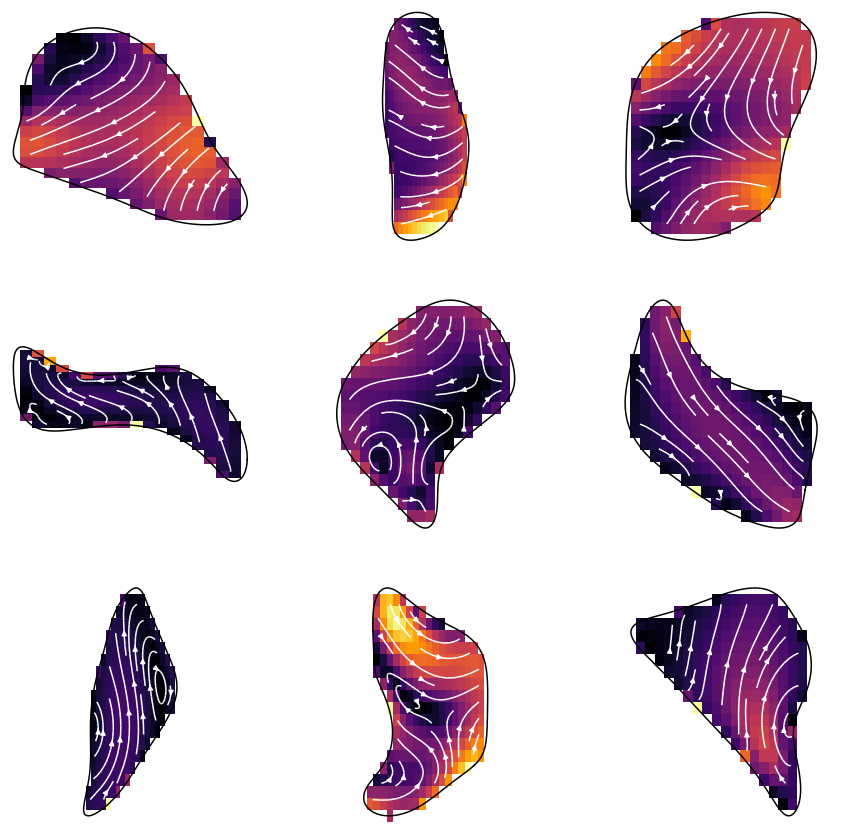

In [3]:
n_res = 128
n_dat = len(pars)

t = np.linspace(0,2*np.pi,n_res+1)[0:-1]


X = np.zeros((n_dat, 8, n_res))
Y = np.zeros((n_dat, 2, n_res))


plt.figure(figsize=(15,15))
for i,par in enumerate(pars):
    ############################################
    # DO FFT ON BOUNDARY PARAMETERISATION
    freq = np.fft.fft(par.squeeze())
    K=len(freq)//2
    freq = np.hstack([freq[K+1:], freq[0:K+1]])
    freq[K] = 0.  # Set translation to 0
    
    ############################################
    # GENERATE BOUNDARY CONDITION
    u_coef = ProblemData.random_fourier_coefs(K, amplitude=0.5, decay=0.4, decay_type="exp")
    
    # For testing: set field to zero except constant term
    # test 1: constant term
    # u_coef = u_coef*0
    # u_coef[K] = 1. + 1j 
    # Test 2: Stirring
    # u_coef = freq * np.arange(-K,K+1) * 1j
    
    ###########################################
    # CREATE PROBLEM DATA STRUCTURE 
    data = ProblemData(freq, u_coef, density_coef=None)
    prob = data.to_problem(n=4) # Refine
    
    # Correct the net flow
    u_coef += prob.fourier_flow_correction(K=K, regpar=3)
    data = ProblemData(freq, u_coef, density_coef=None)
    
    # Solve again with new boundary condition
    print(f"solving system {i+1}/{len(pars)}", end = "\r")
    data.set_density(n=4, tol=1e-8, maxiter=1000)
    prob = data.to_problem(n=4)
    
    
    # Add random variability
    #ks = np.linspace(-K,K,2*K+1)
    #randfreq = np.random.randn(2*K+1)/((1+np.abs(ks))**1) * 0
    #trunc = np.abs(ks) < K+1
    
    #print(freq)
    #func = lambda t: sum([(freq[k+K] + randfreq[k+K]) * trunc[k+K] * np.exp(1j*k*t)/(1+2*K) for k in range(-K,K+1)])
    #func = lambda t: (freq[K-1]*np.exp(-1j*t) + freq[K] + freq[K+1]*np.exp(1j*t)
    
    ###########################################
    # EXTRACT THE DATA
    bound = data.get_bound()
    dbound = data.get_bound(deriv=1)
    ddbound = data.get_bound(deriv=2)
    u0 = data.get_u()
    dens = data.get_density()
    # Is there an error? 
    # - Does it convert to a fourier transform first??
    # - It might, because it is doing fft(ifft())
    # - Tested, error is 1e-7 - 1e-12. Not a problem at all.
    
    z   = bound(t)
    dz  = dbound(t)
    ddz = ddbound(t)
    v0  = u0(t)*1j
    c   = dens(t)
    
    X[i,0,:], X[i,1,:] = np.real(z),   np.imag(z)
    X[i,2,:], X[i,3,:] = np.real(dz),  np.imag(dz)
    X[i,4,:], X[i,5,:] = np.real(ddz), np.imag(ddz)
    X[i,6,:], X[i,7,:] = np.real(v0),  np.imag(v0)
    Y[i,0,:], Y[i,1,:] = np.real(c),   np.imag(c)
    
    ##########################################
    # PLOT VELOCITY + STREAMLINES
    # plot boundary
    
    plt.subplot(M,M,i+1)
    #plt.plot(np.real(z), np.imag(z), linewidth=3)
    field = lambda z: np.abs(prob.evaluate(z))
    prob.geometry.plot(ax = plt.gca(), color="black")
    prob.geometry.plot_field(ax=plt.gca(), func=field, npts=20, apply_mask=True, cmap="inferno")#, vmin=0, vmax=20)
    prob.geometry.plot_stream(ax=plt.gca(), func=prob.evaluate, npts=20, apply_mask=True, color="white", density=0.5)
    remove_axes(plt.gca())
    plt.axis("equal")
    
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

# Set bad domains to zero
norms = Y.norm(dim=(1,2))
for i in range(Y.shape[0]):
    if norms[i]>30:
        Y[i,:,:] *= 0.
        X[i,6:,:] *= 0.

Save the data.

In [48]:
data = {"X":X, "X labels": ["re(z)", "im(z)", "re(dz)", "im(dz)", "re(ddz)", "im(ddz)", "re(v0)", "im(v0)"],
        "Y":Y, "Y labels": ["re(density)", "im(density)"], 
        "info": f"X is (N, C1, M) with N={X.shape[0]} datapoints, C1=8 channels and M={X.shape[2]} discretisation points.\n" 
              + f"Y is (N, C2, M) with N={Y.shape[0]} datapoints, C2=2 channels and M={Y.shape[2]} discretisation points."}

torch.save(data, "/home/emastr/phd/data/discretised_data_gradflow_big_TEST.torch")

Load data and plot

X is (N, C1, M) with N=100 datapoints, C1=8 channels and M=128 discretisation points.
Y is (N, C2, M) with N=100 datapoints, C2=2 channels and M=128 discretisation points.


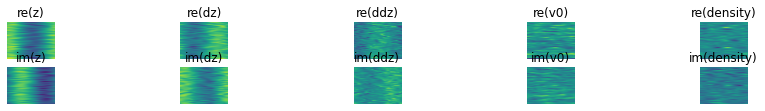

In [49]:
data = torch.load("/home/emastr/phd/data/discretised_data_gradflow_big_TEST.torch")
print(data["info"])
X = data["X"]
Y = data["Y"]


plt.figure(figsize=(15,1.5))
for i,lab in enumerate(data["X labels"]):
    plt.subplot(2,5,1+(i//2)+5*(i%2))
    plt.imshow(X[:,i,:].squeeze().numpy())
    plt.title(lab)
    remove_axes(plt.gca())
    
for i, lab in enumerate(data["Y labels"]):
    plt.subplot(2,5,5*(1+i%2))
    plt.imshow(Y[:,i,:].squeeze().numpy())
    plt.title(lab)
    remove_axes(plt.gca())
    


## Generate random walks

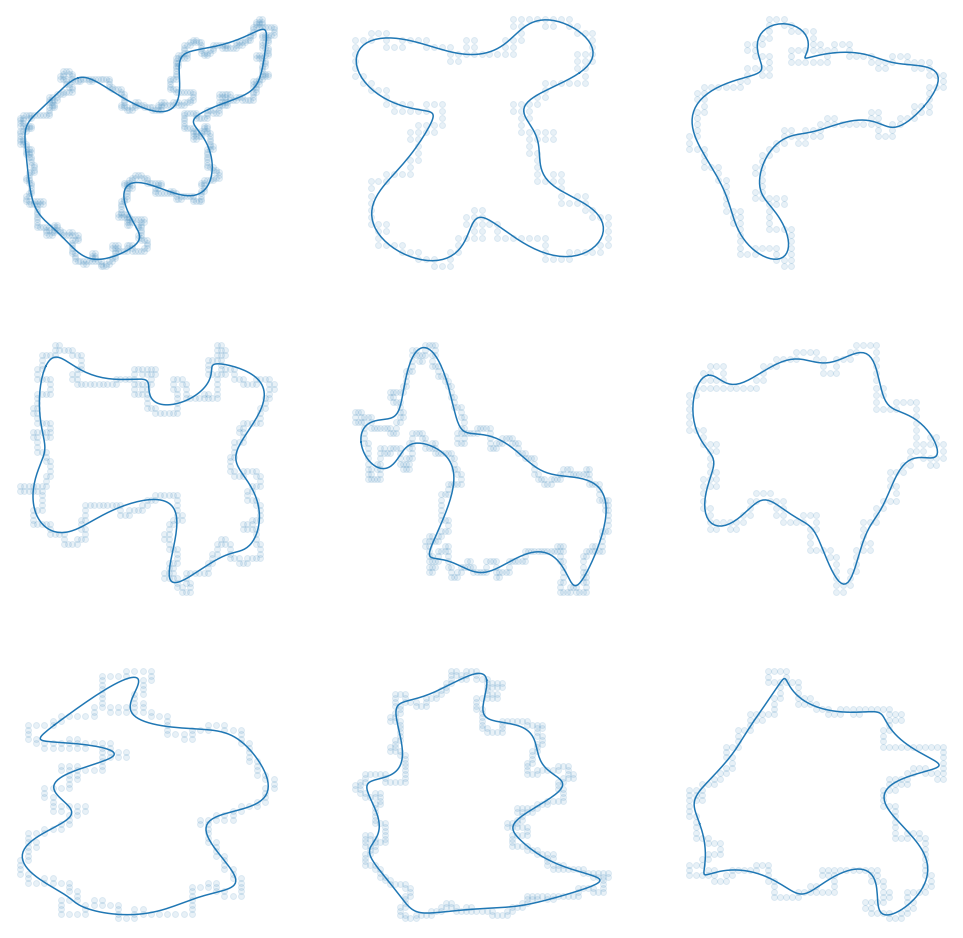

In [49]:
np.random.seed(0)
def loop_erased_rw():
    N = 100
    Nmax = 200

    x,y = [0],[0]
    steps = [(0,1),(0,-1),(-1,0),(1,0)]


    for n in range(100000):
        step_idx = np.random.randint(0,4)
        dx,dy = steps[step_idx]
        xn = x[-1]+dx
        yn = y[-1]+dy

        intersects = [i for i in range(len(y)-1) if x[i]==xn and y[i]==yn]
        assert len(intersects) <= 1, "Something is wrong"

        if len(intersects) == 0:
            x.append(xn)
            y.append(yn)

        elif len(intersects) == 1:
            i = intersects[0]
            if (len(x) - i) >= Nmax:
                x = x[i:]
                y = y[i:]
                break
            else:
                x = x[:i+1]
                y = y[:i+1]        


    # Define numpy arrays
    x = np.array(x)
    y = np.array(y)
    # Center
    x = 2*(x-(min(x)+max(x))/2)/(max(x)-min(x))
    y = 2*(y-(min(y)+max(y))/2)/(max(y)-min(y))
    t = np.linspace(0,2*np.pi,len(x))
    #X,Y
    K = 10
    ks = np.arange(-K, K)

    E = np.exp(1j * ks[None, :] * t[:, None])
    c = np.linalg.solve(np.conjugate(E.T) @ E, np.conjugate(E.T) @ np.hstack([x[:,None], y[:,None]]))
    xy = np.real(E @ c)
    return x, y, xy


M = 3
plt.figure(figsize=(17,17))
pts = []
for i in range(M*M):
    plt.subplot(M,M,i+1)
    x,y,xy = loop_erased_rw()
    pts.append(xy)
    plt.scatter(x,y, alpha=0.1)
    plt.plot(xy[:,0], xy[:, 1])
    remove_axes(plt.gca())

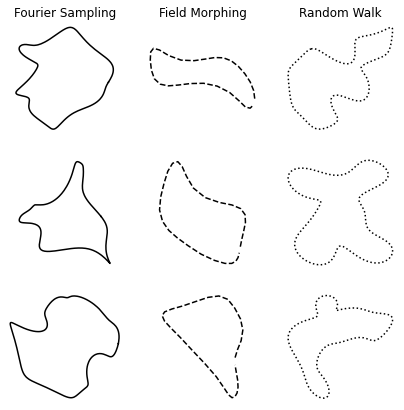

In [61]:
xfour = [np.hstack([np.real(fourpts[i][:,None]), np.imag(fourpts[i][:,None])]) for i in [0,3,5]]
xflow = [np.hstack([np.real(pars[i]), np.imag(pars[i])]) for i in [3,5,8]]
xwalk = [pts[0], pts[1], pts[2]]

names = ["Fourier Sampling", "Field Morphing", "Random Walk"]
examples = [xfour, xflow, xwalk]
col = ["-", "--", ":"]
fig = plt.figure(figsize=(7,7))
for i,example in enumerate(examples):
    plt.subplot(3,3,i+1, title=names[i])
    for j, x in enumerate(example):
        plt.subplot(3,3,i+3*j+1)
        plt.plot(x[:,0], x[:,1], col[i], color='black')
        remove_axes(plt.gca())
        plt.axis("equal")

fig.savefig("/home/emastr/phd/data/random_domain_ex.pdf", bbox_inches="tight")  